In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imripy
from imripy import merger_system as ms

from scipy.interpolate import interp1d

### Define dark matter halo properties

The code works in geometrized units with $c=G=1$, which means that energy, length, time, and mass all have the same units (see for example $E=mc^2 = m$, and $1 = c = \text{length}/\text{time}$)

We can choose which unit we want to describe them with, and usually parsecs is chosen ($1$pc$\approx 3.26$ light years$\approx 3.09\cdot 10^{16}$m). To this end, the imripy.merger_system file has a few constants for the transformation.

In [2]:
# Dark matter spike with the values from the Eda paper
r_spike = 0.54  # in parsecs

alpha = 7./3.

rho_spike = 226. * ms.solar_mass_to_pc  # This takes the value of 226 M_sun/pc^3 and converts it to 1/pc^2

spike = imripy.halo.Spike(rho_spike, r_spike, alpha)

In [3]:
# NFW for comparison
r_s = 23.1
rho_s = 3.8e-22 *ms.g_cm3_to_invpc2
nfw = imripy.halo.NFW(rho_s, r_s)

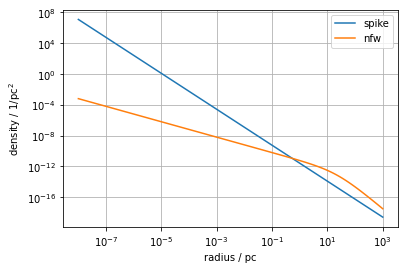

In [4]:
# Plot density
r_grid = np.geomspace(1e-8, 1e3, 100)  # creates a grid in pc
plt.loglog(r_grid, spike.density(r_grid), label='spike')
plt.loglog(r_grid, nfw.density(r_grid), label='nfw')
plt.grid(); plt.xlabel("radius / pc"); plt.ylabel("density / 1/pc$^2$"); plt.legend()

### Define the IMRI system

In [5]:
m1 =  1e4 * ms.solar_mass_to_pc   # The central mass m1 with a mass of 1e3 solar masses, converted to pc

m2 = 1. * ms.solar_mass_to_pc   # The secondary mass

D_luminosity = 5e8              # The distance to the system from earth as 500 Mpc

sp = ms.SystemProp(m1, m2, spike, D_luminosity)   # Create the SystemProp object describing the IMRI system

### Define initial conditions for a circular inspiral

In [7]:
R0 = 50. * sp.r_isco()    # Start the inspiral from an initial separataion of 50 * r_isco, the radius of the 
                            # innermost stable ciricular orbit

R_fin = sp.r_isco()      # The final condition for the evolution

### Solve the differential equations

In [8]:
ev = imripy.inspiral.Classic.Evolve(sp, R0,  a_fin = R_fin)

Evolving from  50.0  to  1.0 r_isco   on circular orbits  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 0.0515s


Text(0, 0.5, 'radius / $r_{isco}$')

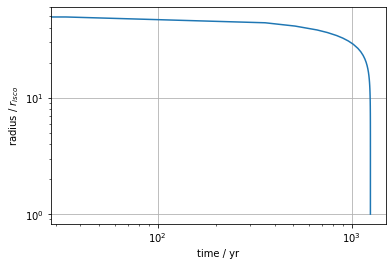

In [9]:
# Plot the result
plt.loglog(ev.t/ms.year_to_pc,  ev.R/sp.r_isco())
plt.grid(); plt.xlabel("time / yr"); plt.ylabel("radius / $r_{isco}$")

### Calculate the gravitational wave signal

/home/codespace/.conda/envs/py3/lib/python3.8/site-packages/imripy/waveform.py:179: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(sp.m_total()/a_int(t)**3) * (1. - e_int(t)**2)**(-3./2.) * (1. + e_int(t)*np.cos(phi))**2


Text(0.5, 0, 'time to merger / s')

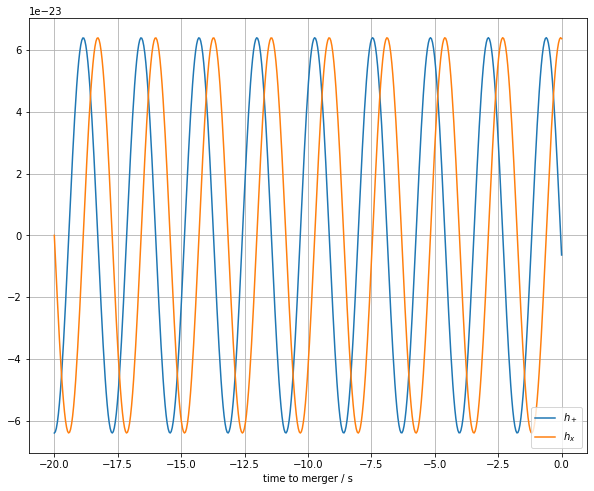

In [10]:
# First, the gravitational wave signal right before inspiral
tom = ev.t[-1]    # time of merger
t_grid = np.linspace(tom - 20.*ms.s_to_pc, tom, 500)   # Look at the last 20s of inspiral
h_plus, h_cross = imripy.waveform.h(sp, ev, t_grid)

plt.figure(figsize=(10,8))
plt.plot((t_grid - tom)/ms.s_to_pc, h_plus, label="$h_+$")
plt.plot((t_grid - tom)/ms.s_to_pc, h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time to merger / s")

Text(0, 0.5, 'characteristic strain')

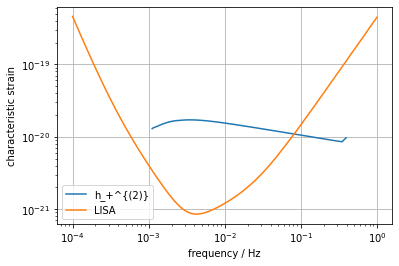

In [11]:
# The characteristic strain (basically fourier transform) of the signal compared to the LISA sensitivity
f_gw, h_2_plus, h_2_cross, _ = imripy.waveform.h_2(sp, ev)
plt.loglog(f_gw/ms.hz_to_invpc, 2.* f_gw*h_2_plus, label="h_+^{(2)}")

Lisa = imripy.detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/ms.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.grid(); plt.legend(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain")

### Calculate dephasing

In [13]:
# To calculate the dephasing, we need the vacuum case
noDF = imripy.inspiral.Classic.EvolutionOptions(dynamicalFrictionLoss=False)
ev_0 = imripy.inspiral.Classic.Evolve(sp, R0, a_fin=R_fin, opt=noDF)

Evolving from  50.0  to  1.0 r_isco   on circular orbits  with  Options:  dynamicalFrictionLoss = False,accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 0.0499s


Text(0, 0.5, '$\\Delta N$')

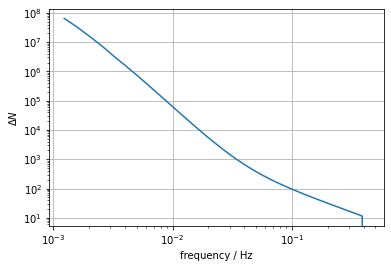

In [14]:
# Now calculate N_cycles for both cases and compare
f_gw_0, N_0 = imripy.waveform.N_cycles_n(2, sp, ev_0)
N_0_interp = interp1d(f_gw_0, N_0, bounds_error=False, fill_value=(0.,0.))

f_gw, N = imripy.waveform.N_cycles_n(2, sp, ev)

plt.loglog(f_gw/ms.hz_to_invpc, np.abs(N_0_interp(f_gw)- N))
plt.grid(); plt.xlabel("frequency / Hz"); plt.ylabel("$\Delta N$")

### Do the same for an eccentric inspiral

In [15]:
a0 = 50. * sp.r_isco()  
e0 = 0.5    

a_fin = sp.r_isco() 

ev_ecc = imripy.inspiral.Classic.Evolve(sp, a0, e_0=e0,  a_fin = R_fin)

Evolving from  50.0  to  1.0 r_isco  with initial eccentricity 0.5  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
A termination event occurred.
 -> Evolution took 0.7398s


Text(0, 0.5, 'radius / $r_{isco}$')

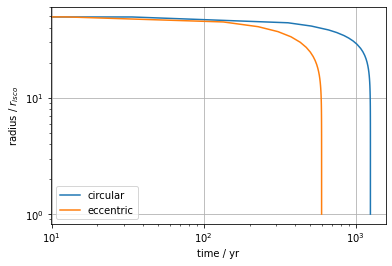

In [16]:
# Plot the result and compare to circular case
plt.loglog(ev.t/ms.year_to_pc,  ev.R/sp.r_isco(), label='circular')
plt.loglog(ev_ecc.t/ms.year_to_pc,  ev_ecc.a/sp.r_isco(), label='eccentric')
plt.grid(); plt.legend(); plt.xlabel("time / yr"); plt.ylabel("radius / $r_{isco}$")

Text(0, 0.5, 'eccentricity')

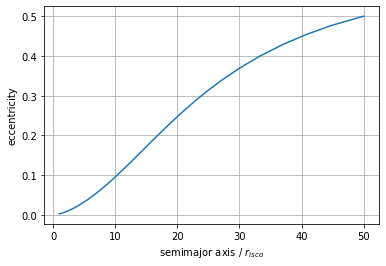

In [18]:
# Plot eccentricity vs semimajor axis
plt.plot(ev_ecc.a/sp.r_isco(),  ev_ecc.e)
plt.grid(); plt.xlabel("semimajor axis / $r_{isco}$"); plt.ylabel("eccentricity")

Text(0.5, 0, 'time / s')

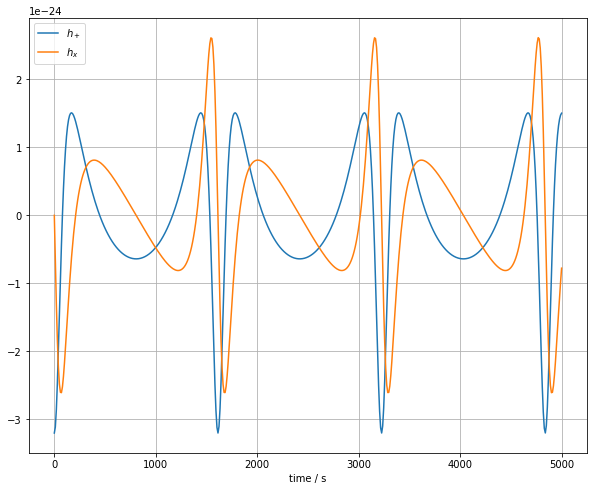

In [19]:
t_grid = np.linspace(0., 5000.*ms.s_to_pc, 500)   # Look at the first 5000s of inspiral to see the eccentric effects
h_plus, h_cross = imripy.waveform.h(sp, ev_ecc, t_grid)

plt.figure(figsize=(10,8))
plt.plot(t_grid/ms.s_to_pc, h_plus, label="$h_+$")
plt.plot(t_grid/ms.s_to_pc, h_cross, label="$h_x$")
plt.grid(); plt.legend(); plt.xlabel("time / s")

(1e-24, 1.222518368692293e-18)

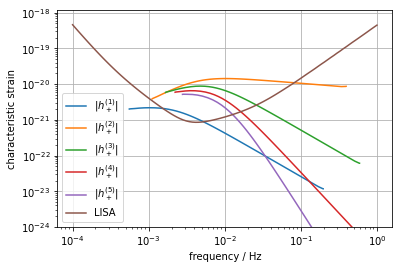

In [20]:
# Plot the first five harmonics
n_comp = 5

wfs = [imripy.waveform.h_n(n, sp, ev_ecc, acc=1e-13) for n in range(1, n_comp+1)]

for i in range( len(wfs)):
    plt.loglog(wfs[i][0]/ms.hz_to_invpc, 2.*wfs[i][0]*np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

Lisa = imripy.detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/ms.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')
plt.grid(); plt.legend(); plt.xlabel("frequency / Hz"); plt.ylabel("characteristic strain"); plt.ylim(bottom=1e-24)

In [22]:
Lisa.Bandwith()

(10290.0, 102900000.0)